# Make Sure the ML Model Fitted Correctly

In [1]:
# Create a strategy using the trained model
# Backtest using timerange TRAINVAL, and pairs of trained model
# Make sure the profit graph is upwards (ofc coz we BT'ed in train and val date)

In [26]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs
import os
import logging
import sys
import nest_asyncio

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.ml import lightning_utils

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    # TODO: Resolve "latest" to number version
    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


# Model Validation

In [27]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.

NOTE 1: Please indent the hashtag when commenting!
NOTE 2: Watch for Average Trade Duration!

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_classes = 5
            dataframe = lightning_container.predict(dataframe)
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            
            # self.print_once(dataframe.info(), "info_df")
            # self.print_once(dataframe.describe(), "describe_df")
            # self.print_once(dataframe, "populate_buy_sell")
            
            return dataframe
    """ End Strategy Code """

You are using LATEST (v1) of '15n30-catboost_intentional'
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v1' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_val_15n30-catboost_intentional ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20160821-20210620
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -99}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -0.99
freqtrade.nbtools.helper - Strategy using trailing_stop: False
freqtrade.nbtools.helper - Strategy using trailing_stop_positive_offset: 0.0
freqtra

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 17.78s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_val_15n30-catboost_intentional__backtest-2021-09-02_21-46-27
freqtrade.nbtools.backtest - with random name: friendly-piccolo-mask
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 25.31s


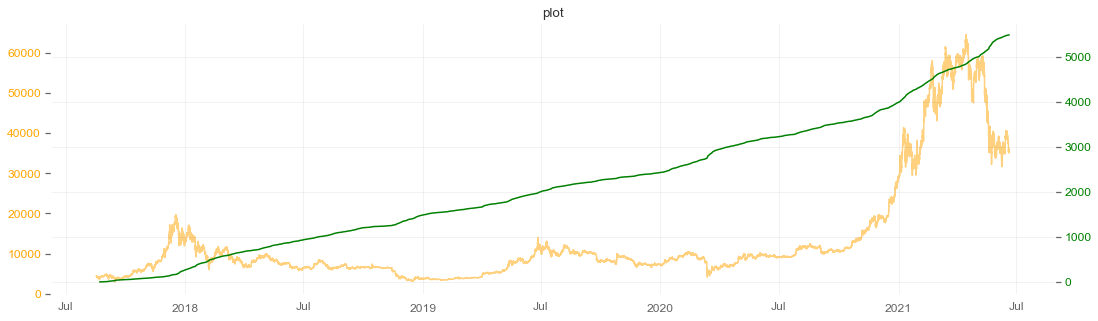

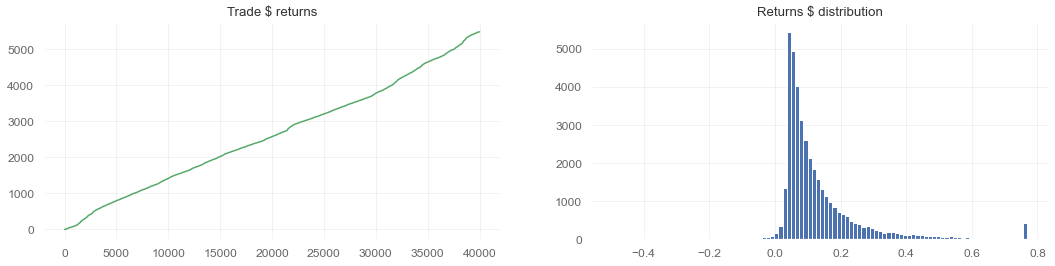

,Portfolio Summary
Trades,40005
Min Balance,0.047825
Max Balance,5489.332463
Final Balance,5489.332463
Avg. Return (%),0.913861
Avg. Trade Duration,0 days 00:35:34
Wins,39681
Loses,324
Win Rate,0.99


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'ml_val_15n30-catboost_intentional__backtest-2021-09-02_21-46-27'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [28]:
MODEL_NAME = "15n30-catboost_l3"
MODEL_VER = "latest"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Model x Strategy Optimization

In [23]:
""" 
In this phase, tinker your strategy until you get the "Sweet Spot"!
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = 5
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                # dataframe['close'] > dataframe['ema'],
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.65,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

You are using LATEST (v0) of '15n30-catboost_l2'
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v0' of project: '15n30-catboost_l2' - asset_name: '15n30-catboost_l2'.
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_opt_15n30-catboost_l2 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210101-20210621
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v0' of project: '15n30-catboost_l2' - asset_name: '15n30-catboost_l2'.
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -99}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -0.99
freqtrade.nbtools.helper - Strategy using tr

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 19.01s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_opt_15n30-catboost_l2__backtest-2021-09-02_16-23-41
freqtrade.nbtools.backtest - with random name: introvert-gabriel-monitor
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 30.19s


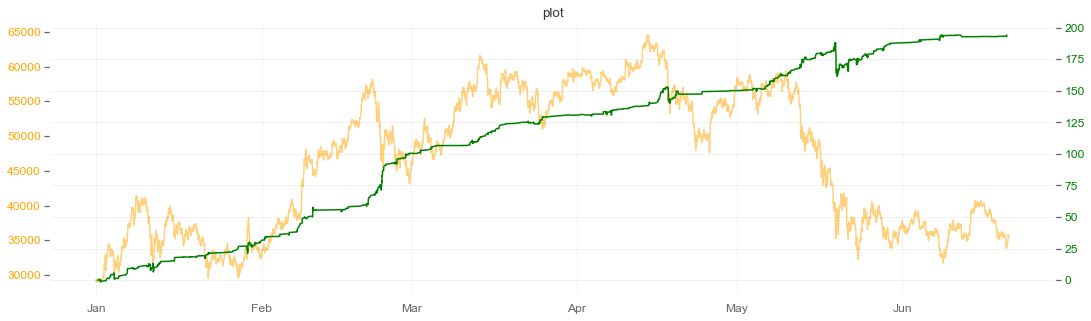

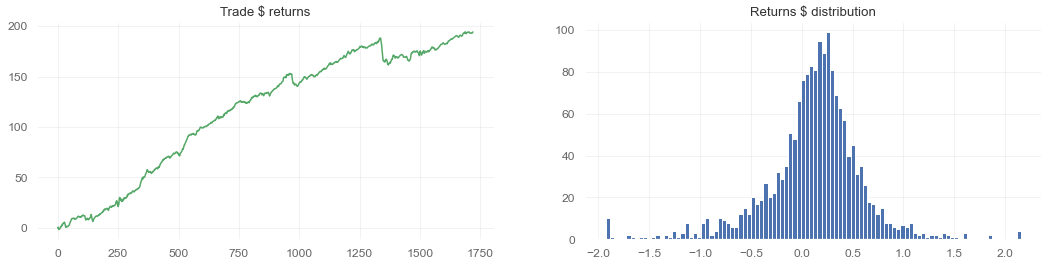

,Portfolio Summary
Trades,1720
Min Balance,-1.450579
Max Balance,194.398245
Final Balance,194.254183
Avg. Return (%),0.752171
Avg. Trade Duration,0 days 00:35:15
Wins,1174
Loses,546
Win Rate,0.68


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'ml_opt_15n30-catboost_l2__backtest-2021-09-02_16-23-41'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [24]:
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Unbiased Backtesting

You are using LATEST (v0) of '15n30-catboost_l2'
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v0' of project: '15n30-catboost_l2' - asset_name: '15n30-catboost_l2'.
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_test_15n30-catboost_l2 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210622-20210820
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v0' of project: '15n30-catboost_l2' - asset_name: '15n30-catboost_l2'.
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -99}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -0.99
freqtrade.nbtools.helper - Strategy using t

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 9.56s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_test_15n30-catboost_l2__backtest-2021-09-02_16-30-33
freqtrade.nbtools.backtest - with random name: smart-spiderman-cable
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 20.61s


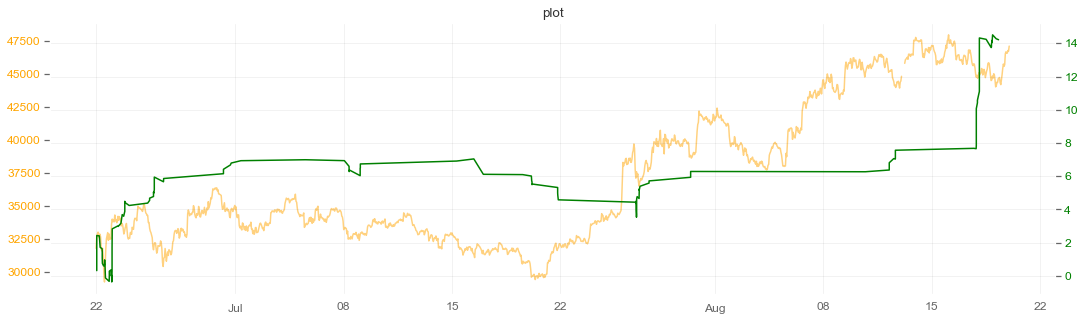

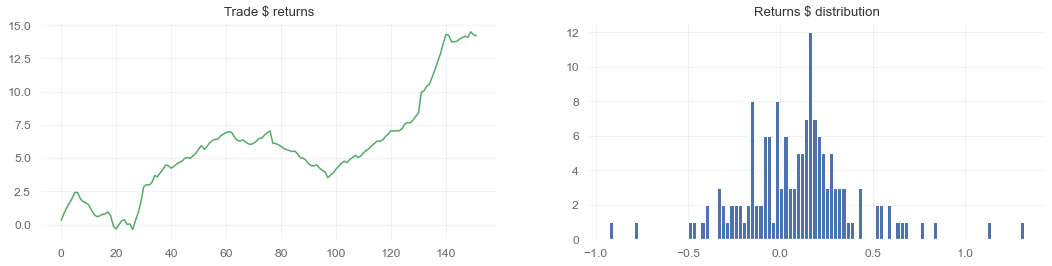

,Portfolio Summary
Trades,152
Min Balance,-0.36857
Max Balance,14.513869
Final Balance,14.219341
Avg. Return (%),0.623032
Avg. Trade Duration,0 days 00:31:58
Wins,96
Loses,56
Win Rate,0.63


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'ml_test_15n30-catboost_l2__backtest-2021-09-02_16-30-33'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [25]:
""" Just run once every "Sweet Spot" you got from Model x Strategy Optimize!"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)